In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from pptx import Presentation
from pptx.util import Inches

In [2]:
# Scraping data
yf.pdr_override() 
start_date = "2023-01-01"
end_date = "2024-02-16"
currency_data = pdr.get_data_yahoo("EURINR=X", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Technical analysis
currency_data['SMA'] = currency_data['Close'].rolling(window=20).mean()
currency_data['EMA'] = currency_data['Close'].ewm(span=20, adjust=False).mean()
currency_data['Middle Band'] = currency_data['Close'].rolling(window=20).mean()
currency_data['Upper Band'] = currency_data['Close'].rolling(window=20).mean() + 2 * currency_data['Close'].rolling(window=20).std()
currency_data['Lower Band'] = currency_data['Close'].rolling(window=20).mean() - 2 * currency_data['Close'].rolling(window=20).std()

In [4]:
def CCI(data, ndays): 
    TP = (data['High'] + data['Low'] + data['Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(window=ndays).mean()) / (0.015 * TP.rolling(window=ndays).std()),
                    name = 'CCI') 
    return CCI

currency_data['CCI'] = CCI(currency_data, 20)

In [5]:
# Decision making
def make_decision(data):
    if data['Close'] > data['SMA'] and data['Close'] > data['EMA']:
        return 'BUY'
    elif data['Close'] < data['SMA'] and data['Close'] < data['EMA']:
        return 'SELL'
    else:
        return 'NEUTRAL'

In [6]:
currency_data['SMA_Decision'] = currency_data.apply(make_decision, axis=1)
currency_data['Bollinger_Band_Decision'] = np.where(currency_data['Close'] > currency_data['Upper Band'], 'SELL',
                                                   np.where(currency_data['Close'] < currency_data['Lower Band'], 'BUY', 'NEUTRAL'))
currency_data['CCI_Decision'] = np.where(currency_data['CCI'] > 100, 'SELL',
                                        np.where(currency_data['CCI'] < -100, 'BUY', 'NEUTRAL'))

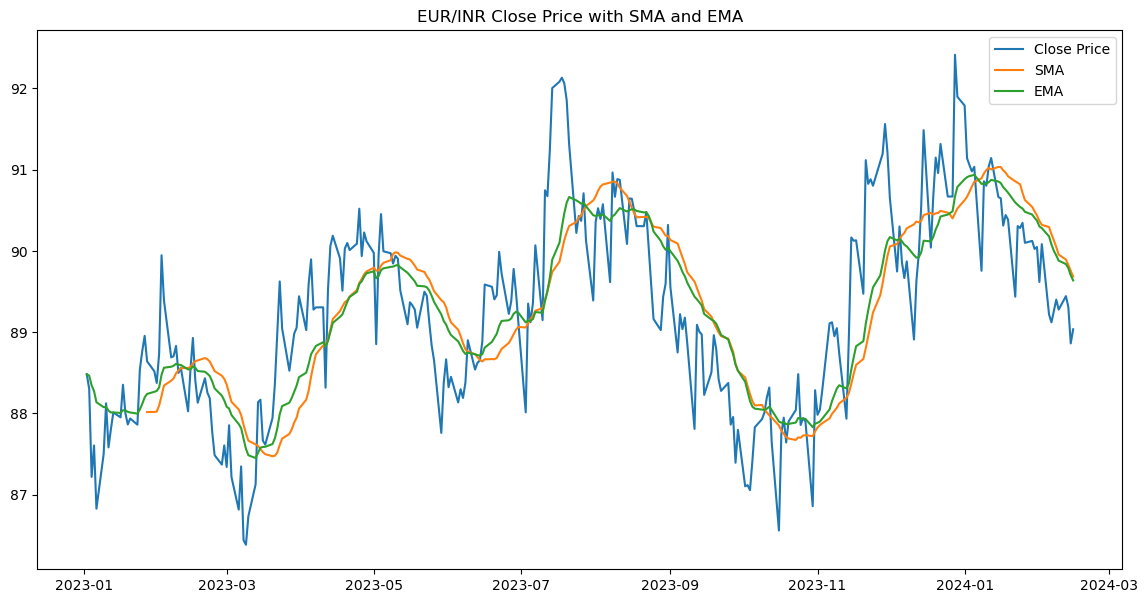

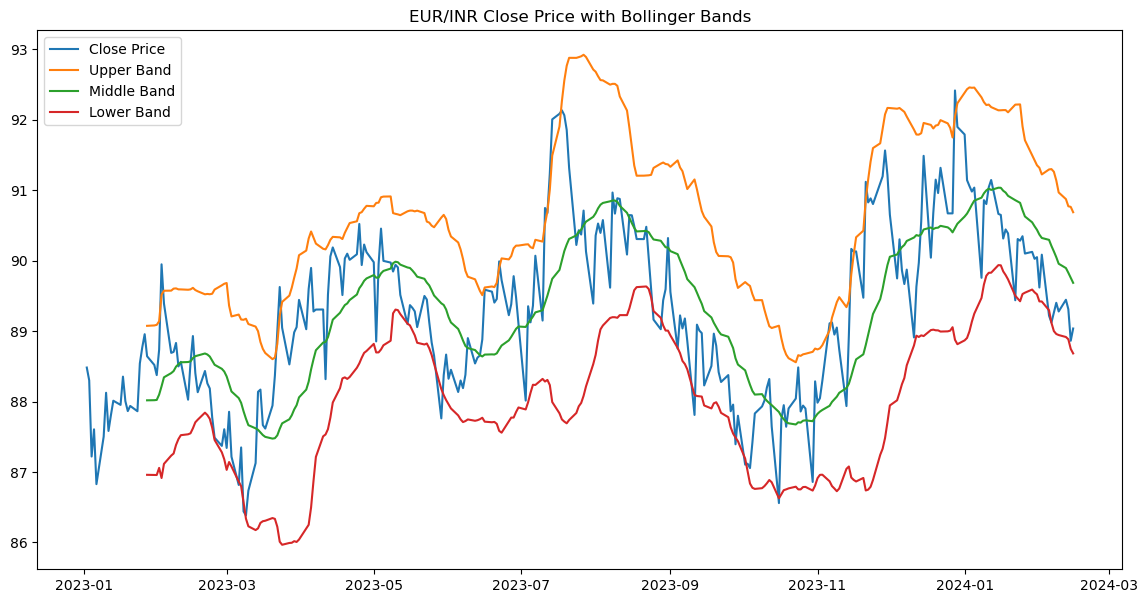

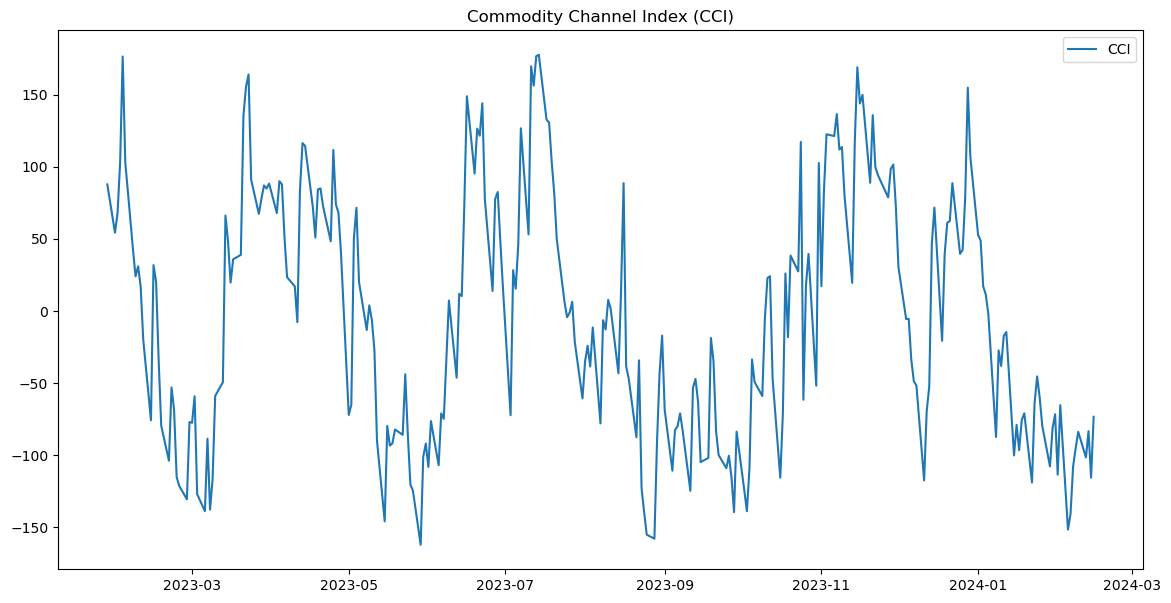

In [7]:
# Visualization
plt.figure(figsize=(14,7))
plt.plot(currency_data['Close'], label='Close Price')
plt.plot(currency_data['SMA'], label='SMA')
plt.plot(currency_data['EMA'], label='EMA')
plt.title('EUR/INR Close Price with SMA and EMA')
plt.legend()
plt.savefig('sma_ema_plot.png')  # Save the plot for inclusion in PowerPoint
plt.show()

plt.figure(figsize=(14,7))
plt.plot(currency_data['Close'], label='Close Price')
plt.plot(currency_data['Upper Band'], label='Upper Band')
plt.plot(currency_data['Middle Band'], label='Middle Band')
plt.plot(currency_data['Lower Band'], label='Lower Band')
plt.title('EUR/INR Close Price with Bollinger Bands')
plt.legend()
plt.savefig('bollinger_bands_plot.png')  # Save the plot for inclusion in PowerPoint
plt.show()

plt.figure(figsize=(14,7))
plt.plot(currency_data['CCI'], label='CCI')
plt.title('Commodity Channel Index (CCI)')
plt.legend()
plt.savefig('cci_plot.png')  # Save the plot for inclusion in PowerPoint
plt.show()

In [8]:
# Output decisions
decision_table = currency_data[['SMA_Decision', 'Bollinger_Band_Decision', 'CCI_Decision']]
decision_table.to_excel('decision_table.xlsx')  # Save decision table as Excel for inclusion in PowerPoint


In [9]:
# Create PowerPoint presentation
prs = Presentation()

In [10]:
# Title slide
slide_title = prs.slides.add_slide(prs.slide_layouts[0])
title = slide_title.shapes.title
subtitle = slide_title.placeholders[1]
title.text = "EUR/INR Currency Analysis"
subtitle.text = "Technical Indicators Forecast"

In [11]:
# Table slide
slide_table = prs.slides.add_slide(prs.slide_layouts[5])
title = slide_table.shapes.title
title.text = "Technical Indicator Decisions"
rows, cols = decision_table.shape
table = slide_table.shapes.add_table(rows + 1, cols, Inches(1), Inches(1.5), Inches(8), Inches(1.5)).table
for i, col in enumerate(decision_table.columns):
    table.cell(0, i).text = col
for r in range(rows):
    for c in range(cols):
        table.cell(r + 1, c).text = str(decision_table.iloc[r, c])

In [12]:
# Graph slides
img_title=['Moving Average-SMA & EMA','Bollinger Band','CCI (Commodity Channel Index)']
img_paths = ['sma_ema_plot.png', 'bollinger_bands_plot.png', 'cci_plot.png']
for i_title, i_path in zip(img_title,img_paths):
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    title=slide.shapes.title
    title.text=i_title
    pic = slide.shapes.add_picture(i_path, Inches(1), Inches(1.5), height=Inches(4.5))

In [13]:
# Save the presentation
prs.save('Currency_Analysis.pptx')